# Click-Through Rate Prediction

In [79]:
import numpy as np
import pandas as pd
import random
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from operator import itemgetter
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score

In [2]:
n = 40428967  #total number of records in the clickstream data 
sample_size = 1000000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 

In [3]:
types_train = {
    'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.dtype(int),
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21':np.dtype(int)
}

types_test = {
    'id': np.dtype(int),
    'hour': np.dtype(int),
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21':np.dtype(int)
}

In [5]:
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

with gzip.open('data/train.gz') as f:
    train = pd.read_csv(f, parse_dates = ['hour'], date_parser = parse_date, dtype=types_train, skiprows = skip_values)

train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,-172049060,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15707,320,50,1722,0,35,-1,79
1,701479546,0,2014-10-21,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,...,1,0,20362,320,50,2333,0,39,100076,157
2,1192804959,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20362,320,50,2333,0,39,-1,157
3,-1476422109,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15708,320,50,1722,0,35,-1,79
4,650537409,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15702,320,50,1722,0,35,-1,79


In [6]:
train.shape

(1000000, 24)

In [7]:
train.dtypes

id                           int32
click                        int32
hour                datetime64[ns]
C1                           int32
banner_pos                   int32
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  int32
device_conn_type             int32
C14                          int32
C15                          int32
C16                          int32
C17                          int32
C18                          int32
C19                          int32
C20                          int32
C21                          int32
dtype: object

Target feature -> click

site features -> site_id, site_domain, site_category

app feature -> app_id, app_domain, app_category

device feature -> device_id, device_ip, device_model, device_type, device_conn_type

anonymized categorical features -> C14-C21

In [8]:
train['click'].value_counts()

0    830365
1    169635
Name: click, dtype: int64

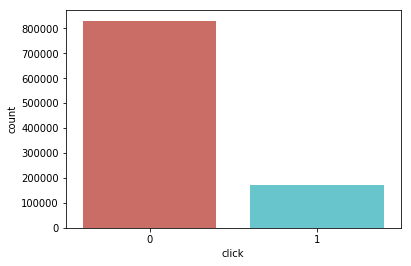

In [10]:
sns.countplot(x='click',data=train, palette='hls')
plt.show();

In [11]:
train['click'].value_counts()/len(train)

0    0.830365
1    0.169635
Name: click, dtype: float64

Click through rate is approx. 17%, and approx. 83% is not clicked. 

In [12]:
train.hour.describe()

count                 1000000
unique                    240
top       2014-10-22 09:00:00
freq                    11120
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

The data covers 10 days of click streams data from 2014-10-21 to 2014-10-30, that is 240 hours.

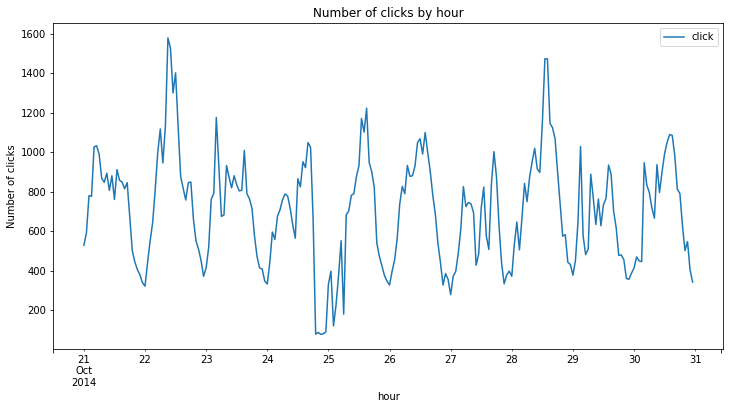

In [13]:
train.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour');

The hourly clicks pattern looks pretty similar every day. However, there were a couple of peak hours, one is sometime in the mid of the day on Oct 22, and another is sometime in the mid of the day on Oct 28. And one off-peak hour is close to mid-night on Oct 24.

###  Feature engineering for date time features

#### Hour

Extract hour from date time feature.

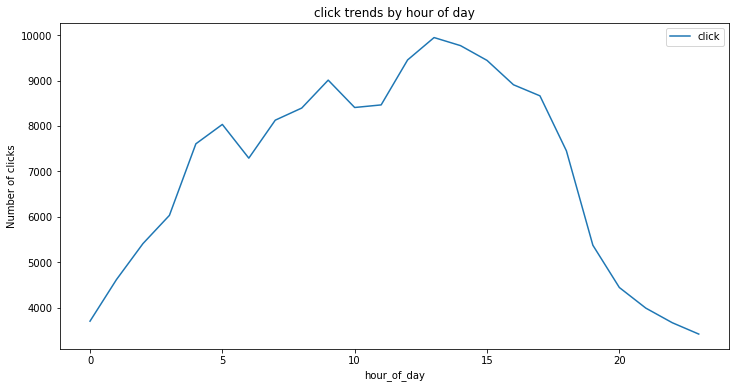

In [14]:
train['hour_of_day'] = train.hour.apply(lambda x: x.hour)
train.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day');

In general, the highest number of clicks is at hour 13 and 14 (1pm and 2pm), and the least number of clicks is at hour 0 (mid-night). It seems a useful feature for roughly estimation.

In [15]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day
0,-172049060,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,2,15707,320,50,1722,0,35,-1,79,0
1,701479546,0,2014-10-21,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,...,0,20362,320,50,2333,0,39,100076,157,0
2,1192804959,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,0,20362,320,50,2333,0,39,-1,157,0


Let's take impressions into consideration.

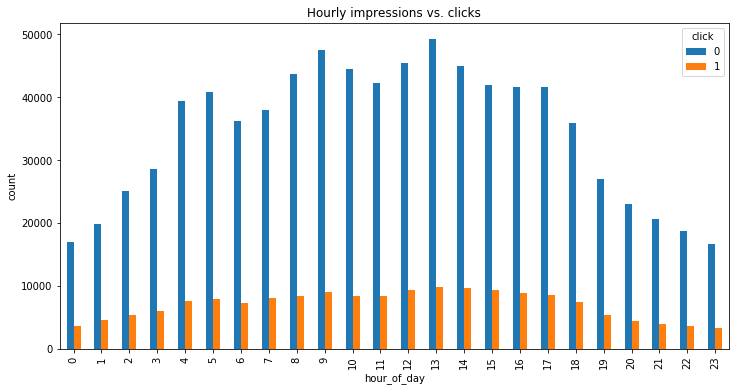

In [16]:
train.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly impressions vs. clicks');

There is nothing shocking here.

In [17]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day
0,-172049060,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,2,15707,320,50,1722,0,35,-1,79,0
1,701479546,0,2014-10-21,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,...,0,20362,320,50,2333,0,39,100076,157,0
2,1192804959,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,0,20362,320,50,2333,0,39,-1,157,0


Now that we have click and impression. We can calculate Click-through rate (CTR). CTR is the ratio of ad clicks to impressions. It measures the rate of clicks on each ad.

#### Hourly CTR

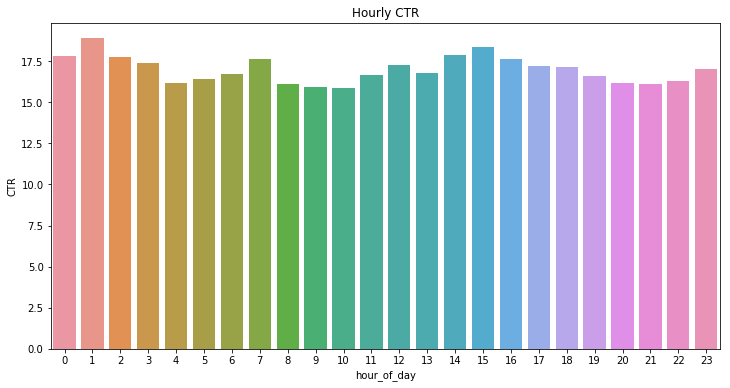

In [18]:
df_click = train[train['click'] == 1]
df_hour = train[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='hour_of_day', data=df_hour)
plt.title('Hourly CTR');

One of the interesting observations here is that the highest CTR happened in the hour of mid-night, 1, 7 and 15. If you remember, around mid-night has the least number of impressions and clicks.

#### Day of week

D:\programs\Continuum\miniconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  """Entry point for launching an IPython kernel.


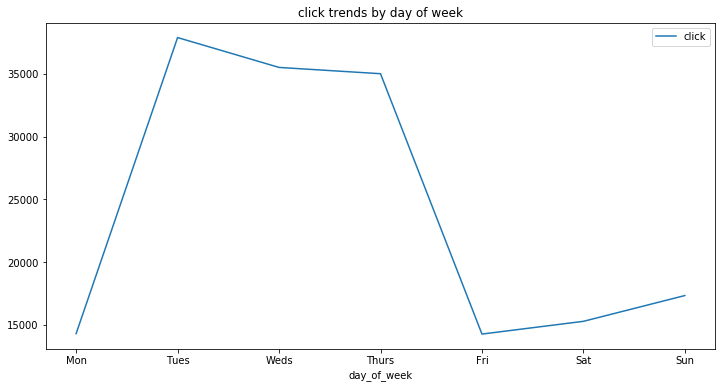

In [19]:
train['day_of_week'] = train['hour'].apply(lambda val: val.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train.groupby('day_of_week').agg({'click':'sum'}).reindex(cats).plot(figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('click trends by day of week');

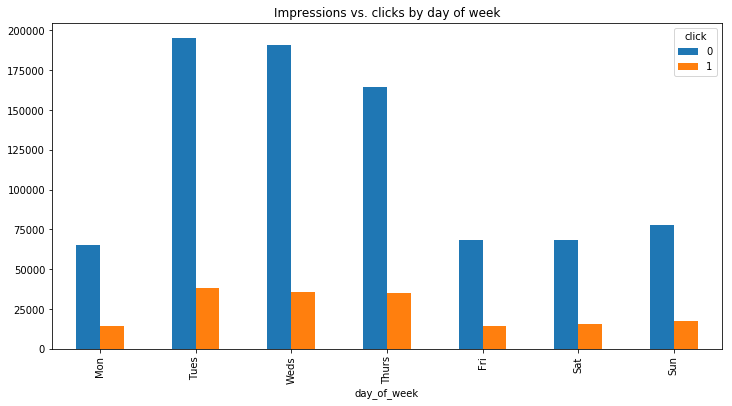

In [20]:
train.groupby(['day_of_week','click']).size().unstack().reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Impressions vs. clicks by day of week');

Tuesdays have the most impressions and clicks, then Wednesdays, followed by Thursdays. Mondays and Fridays have the least number of impressions and clicks.

#### Day of week CTR

In [21]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
0,-172049060,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15707,320,50,1722,0,35,-1,79,0,Tuesday
1,701479546,0,2014-10-21,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,...,20362,320,50,2333,0,39,100076,157,0,Tuesday
2,1192804959,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,20362,320,50,2333,0,39,-1,157,0,Tuesday


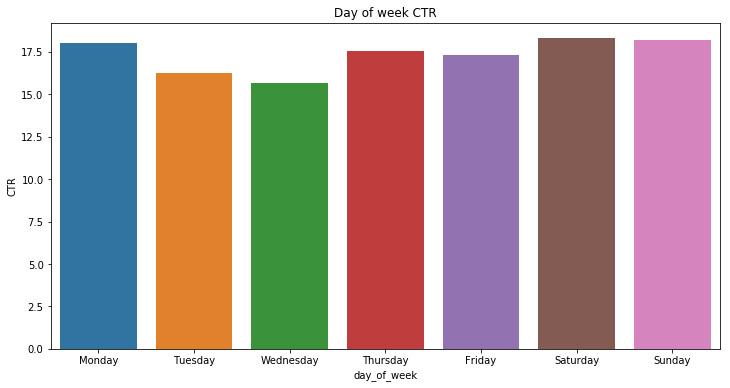

In [22]:
df_click = train[train['click'] == 1]
df_dayofweek = train[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'click': 'impressions'})
df_dayofweek['clicks'] = df_click[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()['click']
df_dayofweek['CTR'] = df_dayofweek['clicks']/df_dayofweek['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR');

While Tuesdays and Wednesdays have the highest number of impressions and clicks, their CTR are among the lowest. Saturdays and Sundays enjoy the highest CTR. Apparently, people have more time to click over the weekend.

In [23]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
0,-172049060,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15707,320,50,1722,0,35,-1,79,0,Tuesday
1,701479546,0,2014-10-21,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,...,20362,320,50,2333,0,39,100076,157,0,Tuesday
2,1192804959,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,20362,320,50,2333,0,39,-1,157,0,Tuesday


### C1 feature

C1 is one of the anonymized categorical features. Although we don't know its meaning, we still want to have a look its distribution.

In [24]:
print(train.C1.value_counts()/len(train))

1005    0.918614
1002    0.054841
1010    0.022401
1012    0.002896
1007    0.000860
1001    0.000245
1008    0.000143
Name: C1, dtype: float64


C1 value = 1005 has the most data, almost 92%. Let's see whether we can find value of C1 indicates something about CTR.

In [25]:
C1_values = train.C1.unique()
C1_values.sort()
ctr_avg_list=[]
for i in C1_values:
    ctr_avg=train.loc[np.where((train.C1 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C1 value: {},  click through rate: {}".format(i,ctr_avg))

for C1 value: 1001,  click through rate: 0.036734693877551024
for C1 value: 1002,  click through rate: 0.21232289710253277
for C1 value: 1005,  click through rate: 0.16900787490719715
for C1 value: 1007,  click through rate: 0.040697674418604654
for C1 value: 1008,  click through rate: 0.1258741258741259
for C1 value: 1010,  click through rate: 0.09682603455202893
for C1 value: 1012,  click through rate: 0.17506906077348067


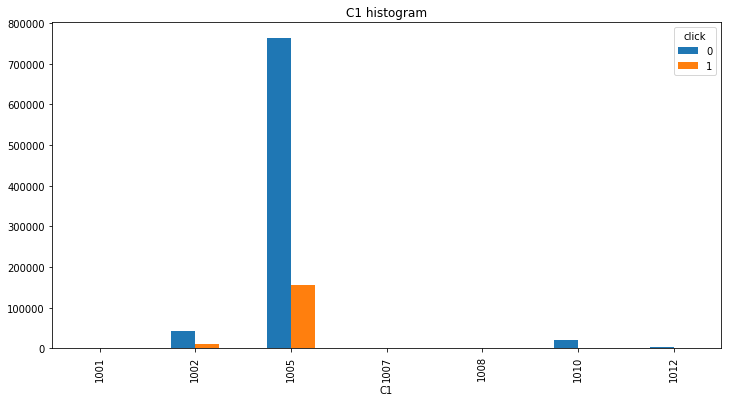

In [26]:
train.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 histogram');

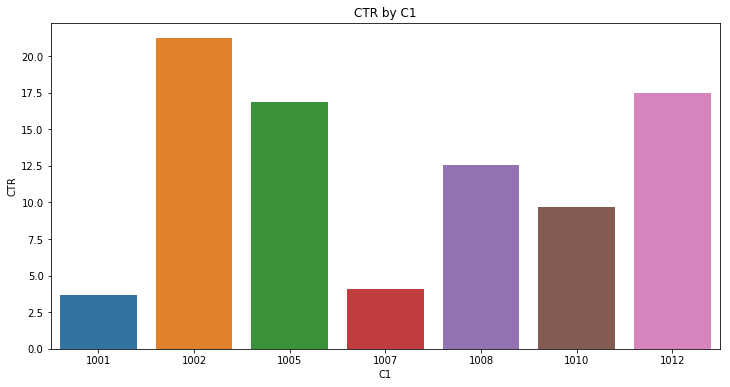

In [27]:
df_c1 = train[['C1','click']].groupby(['C1']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C1','click']].groupby(['C1']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C1', data=df_c1)
plt.title('CTR by C1');

The average CTR in the data is 0.17.

In [28]:
train['click'].mean()

0.169635

In [29]:
df_c1.CTR.describe()

count     7.000000
mean     12.236177
std       6.796121
min       3.673469
25%       6.876185
50%      12.587413
75%      17.203847
max      21.232290
Name: CTR, dtype: float64

The important C1 values and CTR pairs are:

1005: 92% of the data and 0.17 CTR

1002: 5.5% of the data and 0.21 CTR

1010: 2.3% of the data and 0.096 CTR

1002 has a much higher than average CTR, and 1010 has a much lower than average CTR, it seems these two C1 values are important for predicting CTR.

### Banner position

I have heard that there are many factors that affect the performance of your banner ads, but the most influential one is the banner position. Let's see whether it is true.

In [30]:
print(train.banner_pos.value_counts()/len(train))

0    0.719572
1    0.278628
7    0.001092
2    0.000340
4    0.000177
5    0.000143
3    0.000048
Name: banner_pos, dtype: float64


In [31]:
banner_pos = train.banner_pos.unique()
banner_pos.sort()
ctr_avg_list=[]
for i in banner_pos:
    ctr_avg=train.loc[np.where((train.banner_pos == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for banner position: {},  click through rate: {}".format(i,ctr_avg))

for banner position: 0,  click through rate: 0.1639613548053565
for banner position: 1,  click through rate: 0.18376832192026646
for banner position: 2,  click through rate: 0.11470588235294117
for banner position: 3,  click through rate: 0.22916666666666666
for banner position: 4,  click through rate: 0.23163841807909605
for banner position: 5,  click through rate: 0.1258741258741259
for banner position: 7,  click through rate: 0.31227106227106227


The important banner positions are:

position 0: 72% of the data and 0.16 CTR

position 1: 28% of the data and 0.18 CTR

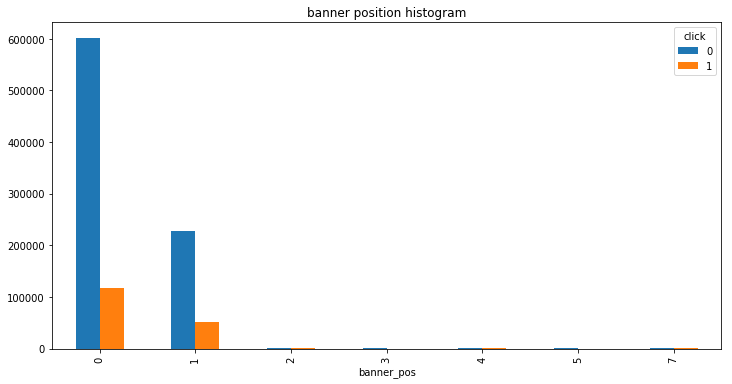

In [32]:
train.groupby(['banner_pos', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='banner position histogram');

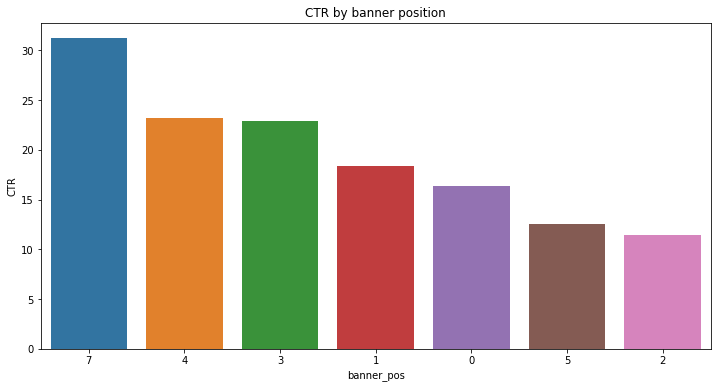

In [33]:
df_banner = train[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()
df_banner = df_banner.rename(columns={'click': 'impressions'})
df_banner['clicks'] = df_click[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()['click']
df_banner['CTR'] = df_banner['clicks']/df_banner['impressions']*100
sort_banners = df_banner.sort_values(by='CTR',ascending=False)['banner_pos'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='banner_pos', data=df_banner, order=sort_banners)
plt.title('CTR by banner position');

In [34]:
df_banner.CTR.describe()

count     7.000000
mean     19.448369
std       6.901141
min      11.470588
25%      14.491774
50%      18.376832
75%      23.040254
max      31.227106
Name: CTR, dtype: float64

Although banner position 0 and 1 have the highest number of impressions and clicks, banner 7 enjoys the highest click through rate. Increasing the number of ads placed on banner position 7 seems to be a good idea.

### Site features

#### site id

In [35]:
print("There are {} sites in the data set".format(train.site_id.nunique()))

There are 2648 sites in the data set


In [36]:
print('The top 10 site ids that have the most impressions')
print((train.site_id.value_counts()/len(train))[0:10])

The top 10 site ids that have the most impressions
85f751fd    0.361431
1fbe01fe    0.160285
e151e245    0.065366
d9750ee7    0.024019
5b08c53b    0.022631
5b4d2eda    0.019156
856e6d3f    0.019054
a7853007    0.011472
b7e9786d    0.009137
5ee41ff2    0.008532
Name: site_id, dtype: float64


In [37]:
top10_ids = (train.site_id.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_ids:
    click_avg=train.loc[np.where((train.site_id == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for site id value: {},  click through rate: {}".format(i,click_avg))

for site id value: 85f751fd,  click through rate: 0.1184375440955535
for site id value: 1fbe01fe,  click through rate: 0.20439217643572385
for site id value: e151e245,  click through rate: 0.2961937398647615
for site id value: d9750ee7,  click through rate: 0.2802364794537658
for site id value: 5b08c53b,  click through rate: 0.4623746188855994
for site id value: 5b4d2eda,  click through rate: 0.12920233869283776
for site id value: 856e6d3f,  click through rate: 0.04214338196704104
for site id value: a7853007,  click through rate: 0.10033124128312412
for site id value: b7e9786d,  click through rate: 0.07715880485936302
for site id value: 5ee41ff2,  click through rate: 0.3270042194092827


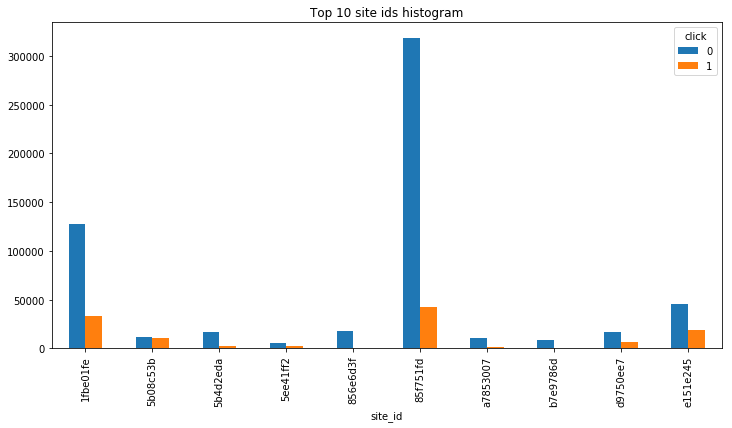

In [38]:
top10_sites = train[(train.site_id.isin((train.site_id.value_counts()/len(train))[0:10].index))]
top10_sites_click = top10_sites[top10_sites['click'] == 1]
top10_sites.groupby(['site_id', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 site ids histogram');

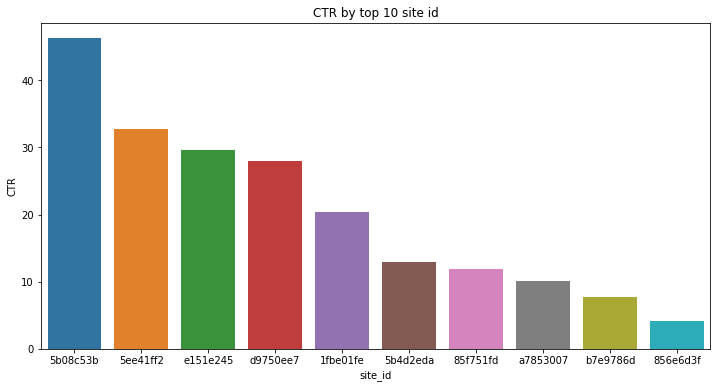

In [39]:
df_site = top10_sites[['site_id','click']].groupby(['site_id']).count().reset_index()
df_site = df_site.rename(columns={'click': 'impressions'})
df_site['clicks'] = top10_sites_click[['site_id','click']].groupby(['site_id']).count().reset_index()['click']
df_site['CTR'] = df_site['clicks']/df_site['impressions']*100
sort_site = df_site.sort_values(by='CTR',ascending=False)['site_id'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='site_id', data=df_site, order=sort_site)
plt.title('CTR by top 10 site id');

The site_id feature seems important because the CTR for the top 10 sites, some as high as 0.47, and some as low as 0.04, and they are significantly different from overall CTR 0.16.

#### site domain 

In [40]:
print("There are {} site domains in the data set".format(train.site_domain.nunique()))

There are 2887 site domains in the data set


In [41]:
print('The top 10 site domains that have the most impressions')
print((train.site_domain.value_counts()/len(train))[0:10])

The top 10 site domains that have the most impressions
c4e18dd6    0.374690
f3845767    0.160285
7e091613    0.082302
7687a86e    0.032051
98572c79    0.024825
16a36ef3    0.021200
58a89a43    0.019054
9d54950b    0.009269
b12b9f85    0.009247
17d996e6    0.008642
Name: site_domain, dtype: float64


In [42]:
top10_domains = (train.site_domain.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_domains:
    click_avg=train.loc[np.where((train.site_domain == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for site domain value: {},  click through rate: {}".format(i,click_avg))

for site domain value: c4e18dd6,  click through rate: 0.12256265179214818
for site domain value: f3845767,  click through rate: 0.20439217643572385
for site domain value: 7e091613,  click through rate: 0.25806177249641565
for site domain value: 7687a86e,  click through rate: 0.45658481794639794
for site domain value: 98572c79,  click through rate: 0.27492447129909364
for site domain value: 16a36ef3,  click through rate: 0.1419811320754717
for site domain value: 58a89a43,  click through rate: 0.04214338196704104
for site domain value: 9d54950b,  click through rate: 0.10907325493580754
for site domain value: b12b9f85,  click through rate: 0.07721423164269493
for site domain value: 17d996e6,  click through rate: 0.3238833603332562


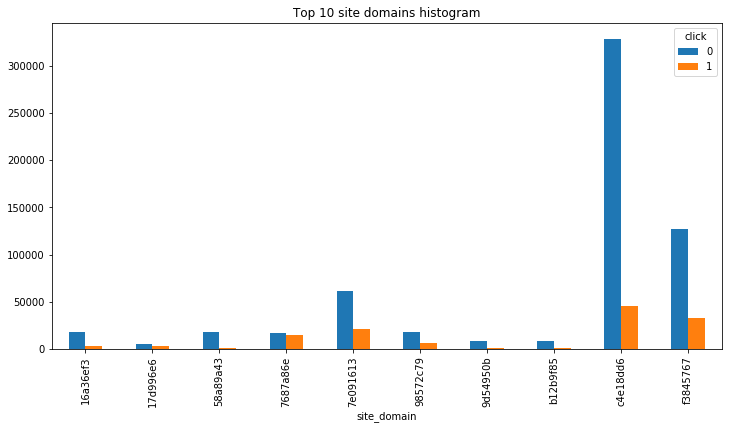

In [43]:
top10_domain = train[(train.site_domain.isin((train.site_domain.value_counts()/len(train))[0:10].index))]
top10_domain_click = top10_domain[top10_domain['click'] == 1]
top10_domain.groupby(['site_domain', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 site domains histogram');

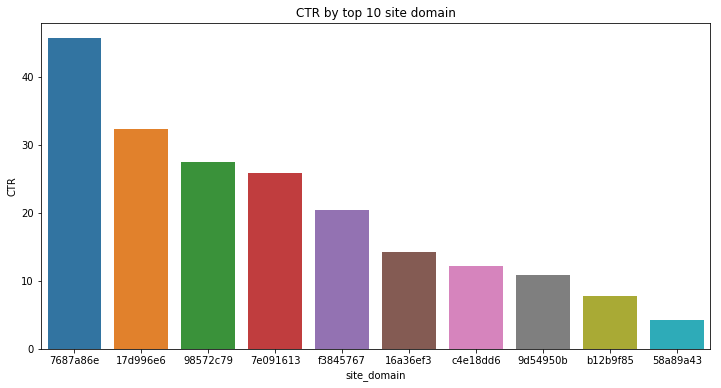

In [44]:
df_domain = top10_domain[['site_domain','click']].groupby(['site_domain']).count().reset_index()
df_domain = df_domain.rename(columns={'click': 'impressions'})
df_domain['clicks'] = top10_domain_click[['site_domain','click']].groupby(['site_domain']).count().reset_index()['click']
df_domain['CTR'] = df_domain['clicks']/df_domain['impressions']*100
sort_domain = df_domain.sort_values(by='CTR',ascending=False)['site_domain'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='site_domain', data=df_domain, order=sort_domain)
plt.title('CTR by top 10 site domain');

Similar with the site_id feature, the site_domain feature seems important as well.

#### site category

In [45]:
print("There are {} site categories in the data set".format(train.site_category.nunique()))

There are 23 site categories in the data set


In [46]:
print('The top 10 site categories that have the most impressions')
print((train.site_category.value_counts()/len(train))[0:10])

The top 10 site categories that have the most impressions
50e219e0    0.409347
f028772b    0.312583
28905ebd    0.182387
3e814130    0.075718
f66779e6    0.006199
75fa27f6    0.004025
335d28a8    0.003484
76b2941d    0.002540
c0dd3be3    0.001100
72722551    0.000671
Name: site_category, dtype: float64


In [47]:
top10_categories = (train.site_category.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_categories:
    click_avg=train.loc[np.where((train.site_category == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for site category value: {},  click through rate: {}".format(i,click_avg))

for site category value: 50e219e0,  click through rate: 0.12840695058226884
for site category value: f028772b,  click through rate: 0.18033290358080895
for site category value: 28905ebd,  click through rate: 0.2073612702659729
for site category value: 3e814130,  click through rate: 0.280593782191817
for site category value: f66779e6,  click through rate: 0.0393611872882723
for site category value: 75fa27f6,  click through rate: 0.0986335403726708
for site category value: 335d28a8,  click through rate: 0.09557979334098737
for site category value: 76b2941d,  click through rate: 0.027559055118110236
for site category value: c0dd3be3,  click through rate: 0.09545454545454546
for site category value: 72722551,  click through rate: 0.06557377049180328


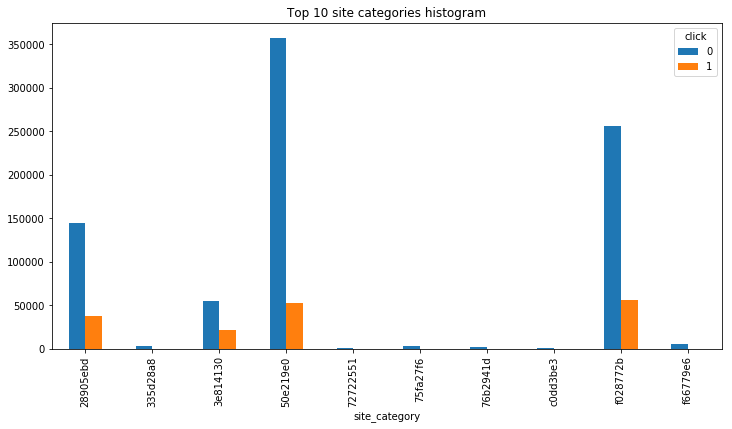

In [48]:
top10_category = train[(train.site_category.isin((train.site_category.value_counts()/len(train))[0:10].index))]
top10_category_click = top10_category[top10_category['click'] == 1]
top10_category.groupby(['site_category', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 site categories histogram');

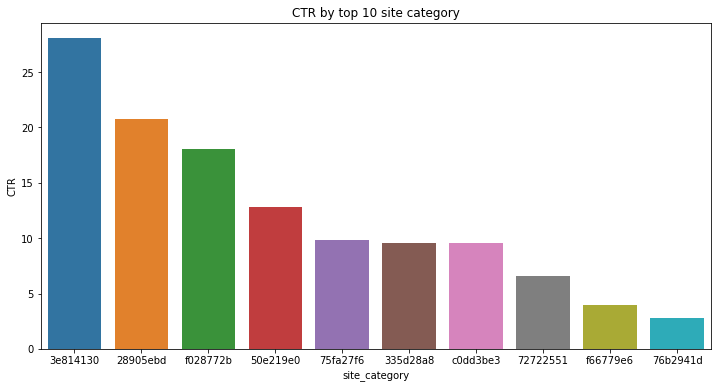

In [49]:
df_category = top10_category[['site_category','click']].groupby(['site_category']).count().reset_index()
df_category = df_category.rename(columns={'click': 'impressions'})
df_category['clicks'] = top10_category_click[['site_category','click']].groupby(['site_category']).count().reset_index()['click']
df_category['CTR'] = df_category['clicks']/df_category['impressions']*100
sort_category = df_category.sort_values(by='CTR',ascending=False)['site_category'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='site_category', data=df_category, order=sort_category)
plt.title('CTR by top 10 site category');

### Device features

#### device id

In [50]:
print("There are {} devices in the data set".format(train.device_id.nunique()))

There are 150686 devices in the data set


In [51]:
print('The top 10 devices that have the most impressions')
print((train.device_id.value_counts()/len(train))[0:10])

The top 10 devices that have the most impressions
a99f214a    0.824672
0f7c61dc    0.000544
c357dbff    0.000543
936e92fb    0.000339
afeffc18    0.000256
987552d1    0.000110
d857ffbb    0.000108
cef4c8cc    0.000102
28dc8687    0.000090
b09da1c4    0.000082
Name: device_id, dtype: float64


In [52]:
top10_devices = (train.device_id.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_devices:
    click_avg=train.loc[np.where((train.device_id == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for device id value: {},  click through rate: {}".format(i,click_avg))

for device id value: a99f214a,  click through rate: 0.1739576461914555
for device id value: 0f7c61dc,  click through rate: 0.7555147058823529
for device id value: c357dbff,  click through rate: 0.6243093922651933
for device id value: 936e92fb,  click through rate: 0.058997050147492625
for device id value: afeffc18,  click through rate: 0.2421875
for device id value: 987552d1,  click through rate: 0.0
for device id value: d857ffbb,  click through rate: 0.2222222222222222
for device id value: cef4c8cc,  click through rate: 0.29411764705882354
for device id value: 28dc8687,  click through rate: 0.0
for device id value: b09da1c4,  click through rate: 0.13414634146341464


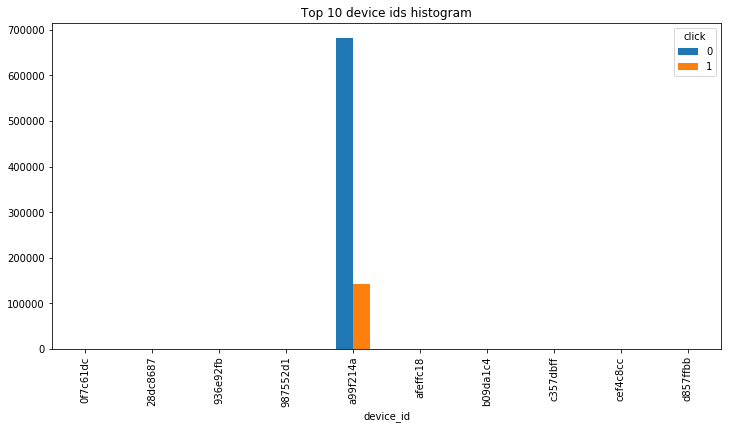

In [53]:
top10_device = train[(train.device_id.isin((train.device_id.value_counts()/len(train))[0:10].index))]
top10_device_click = top10_device[top10_device['click'] == 1]
top10_device.groupby(['device_id', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 device ids histogram');

You will see that most of device_id is a99f214a : Approx. 83% of the data, and the second major device_id is only 0.05% of the data. And there are some extremely high CTR here with device id at 0f7c61dc.

#### device ip

Device ip is more of a users ip address, so, there are a lot of them.

In [54]:
print("There are {} device ips in the data set".format(train.device_ip.nunique()))
print("There are {} device types in the data set".format(train.device_type.nunique()))
print("There are {} device models in the data set".format(train.device_model.nunique()))
print("There are {} device cnn types in the data set".format(train.device_conn_type.nunique()))

There are 556355 device ips in the data set
There are 4 device types in the data set
There are 5145 device models in the data set
There are 4 device cnn types in the data set


#### device type

In [55]:
print('The impressions by device types')
print((train.device_type.value_counts()/len(train)))

The impressions by device types
1    0.922758
0    0.054841
4    0.019201
5    0.003200
Name: device_type, dtype: float64


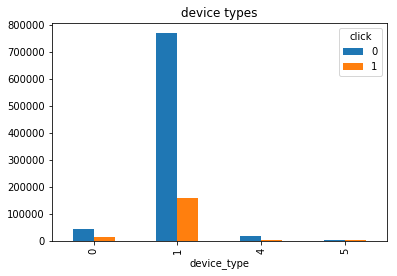

In [56]:
train[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar', title='device types');

Device type 1 gets the most impressions and clicks. And the other device types only get the minimum impressions and clicks. We may want to look in more details about device type 1. 

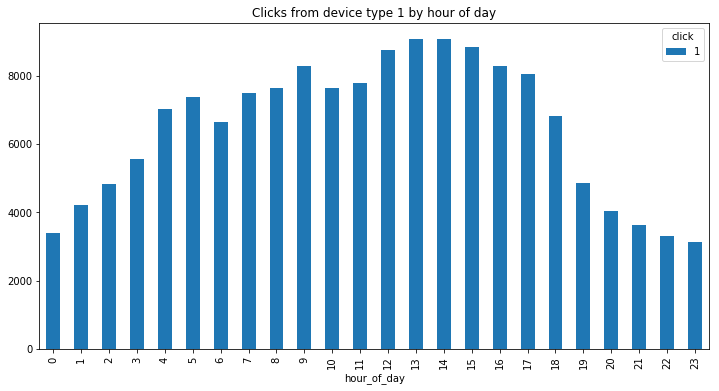

In [57]:
df_click[df_click['device_type']==1].groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Clicks from device type 1 by hour of day", figsize=(12,6));

As expected, most clicks happened during the business hours from device type 1. device type is definitely an important feature. 

In [58]:
device_type_click = df_click.groupby('device_type').agg({'click':'sum'}).reset_index()
device_type_impression = train.groupby('device_type').agg({'click':'count'}).reset_index().rename(columns={'click': 'impressions'})
merged_device_type = pd.merge(left = device_type_click , right = device_type_impression, how = 'inner', on = 'device_type')

In [59]:
merged_device_type['CTR'] = merged_device_type['click'] / merged_device_type['impressions']*100

In [60]:
merged_device_type

,device_type,click,impressions,CTR
0,0,11644,54841,21.232290
1,1,155822,922758,16.886551
2,4,1866,19201,9.718244
3,5,303,3200,9.468750


The highest CTR comes from device type 0.

#### app features

In [61]:
print("There are {} apps in the data set".format(train.app_id.nunique()))
print("There are {} app domains in the data set".format(train.app_domain.nunique()))
print("There are {} app categories in the data set".format(train.app_category.nunique()))

There are 3165 apps in the data set
There are 184 app domains in the data set
There are 27 app categories in the data set


Looks like app category something worth to explore.

In [62]:
print('The impressions by app categories')
print((train.app_category.value_counts()/len(train)))

The impressions by app categories
07d7df22    0.646864
0f2161f8    0.236161
cef3e649    0.043064
8ded1f7a    0.036600
f95efa07    0.028245
d1327cf5    0.003117
09481d60    0.001388
dc97ec06    0.001309
75d80bbe    0.001026
fc6fa53d    0.000610
4ce2e9fc    0.000501
879c24eb    0.000336
a3c42688    0.000293
0f9a328c    0.000136
4681bb9d    0.000132
a86a3e89    0.000070
2281a340    0.000065
8df2e842    0.000030
79f0b860    0.000012
7113d72a    0.000008
a7fd01ec    0.000008
18b1e0be    0.000007
0bfbc358    0.000007
2fc4f2aa    0.000006
5326cf99    0.000003
bf8ac856    0.000001
0d82db25    0.000001
Name: app_category, dtype: float64


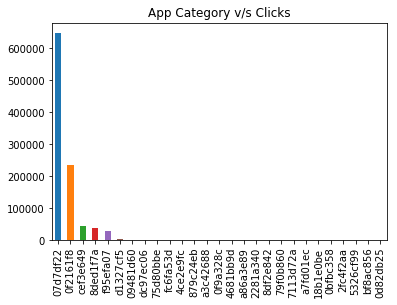

In [63]:
train['app_category'].value_counts().plot(kind='bar', title='App Category v/s Clicks')

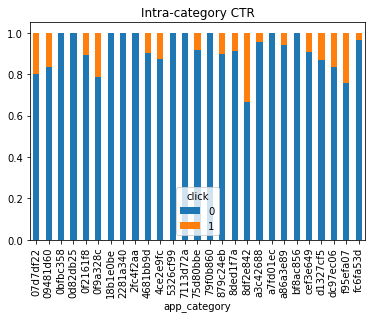

In [64]:
train_app_category = train.groupby(['app_category', 'click']).size().unstack()
train_app_category.div(train_app_category.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR");

#### C14 - C21 features

In [65]:
print("There are {} C14 in the data set".format(train.C14.nunique()))
print("There are {} C15 in the data set".format(train.C15.nunique()))
print("There are {} C16 in the data set".format(train.C16.nunique()))
print("There are {} C17 in the data set".format(train.C17.nunique()))
print("There are {} C18 in the data set".format(train.C18.nunique()))
print("There are {} C19 in the data set".format(train.C19.nunique()))
print("There are {} C20 in the data set".format(train.C20.nunique()))

There are 2246 C14 in the data set
There are 8 C15 in the data set
There are 9 C16 in the data set
There are 421 C17 in the data set
There are 4 C18 in the data set
There are 65 C19 in the data set
There are 164 C20 in the data set


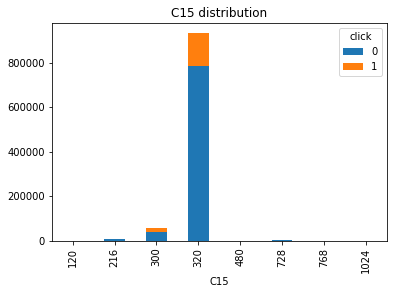

In [66]:
train.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C15 distribution');

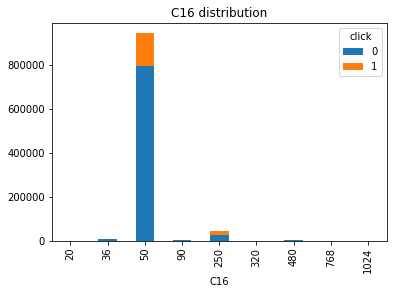

In [67]:
train.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C16 distribution');

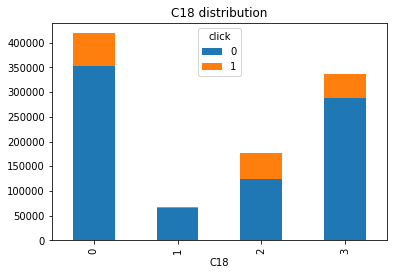

In [68]:
train.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C18 distribution');

In [69]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
0,-172049060,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15707,320,50,1722,0,35,-1,79,0,Tuesday
1,701479546,0,2014-10-21,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,...,20362,320,50,2333,0,39,100076,157,0,Tuesday
2,1192804959,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,20362,320,50,2333,0,39,-1,157,0,Tuesday


In [70]:
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
train = convert_obj_to_int(train)

In [72]:
train.head(3)

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,...,site_id_int,site_domain_int,site_category_int,app_id_int,app_domain_int,app_category_int,device_id_int,device_ip_int,device_model_int,day_of_week_int
0,-172049060,1,2014-10-21,1005,0,1,2,15707,320,50,...,-4278536047757177122,-5877314321906843977,1164242579765219336,700275635474601917,2543806775940094785,-5313447755651138682,3433051248074980704,4968346081219947287,-3610471015970854311,-9045308006594608728
1,701479546,0,2014-10-21,1005,1,1,0,20362,320,50,...,6852104900042245697,-8568657498357606367,-7831981431746288071,700275635474601917,2543806775940094785,-5313447755651138682,3433051248074980704,-4992263366708819401,8951889793082021818,-9045308006594608728
2,1192804959,0,2014-10-21,1005,0,1,0,20362,320,50,...,-1856578371827726122,-3039273878892128088,-4396179870148682145,700275635474601917,2543806775940094785,-5313447755651138682,3433051248074980704,3175177392430799516,-6351974479292244473,-9045308006594608728


In [73]:
train.drop('hour', axis=1, inplace=True)

In [74]:
train.drop('id', axis=1, inplace=True)

In [76]:
X_train = train.loc[:, train.columns != 'click']
y_target = train.click.values
#create lightgbm dataset
msk = np.random.rand(len(X_train)) < 0.8
lgb_train = lgb.Dataset(X_train[msk], y_target[msk])
lgb_eval = lgb.Dataset(X_train[~msk], y_target[~msk], reference=lgb_train)

In [77]:
# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 31, # defauly leaves(31) amount for each tree
    'learning_rate': 0.08,
    'feature_fraction': 0.7, # will select 70% features before training each tree
    'bagging_fraction': 0.3, #feature_fraction, but this will random select part of data
    'bagging_freq': 5, #  perform bagging at every 5 iteration
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                early_stopping_rounds=500)

Start training...
[1]	valid_0's binary_logloss: 0.656592
Train until valid scores didn't improve in 500 rounds.
[2]	valid_0's binary_logloss: 0.625576
[3]	valid_0's binary_logloss: 0.598858
[4]	valid_0's binary_logloss: 0.575842
[5]	valid_0's binary_logloss: 0.556048
[6]	valid_0's binary_logloss: 0.538707
[7]	valid_0's binary_logloss: 0.523649
[8]	valid_0's binary_logloss: 0.510531
[9]	valid_0's binary_logloss: 0.499084
[10]	valid_0's binary_logloss: 0.488981
[11]	valid_0's binary_logloss: 0.480036
[12]	valid_0's binary_logloss: 0.47231
[13]	valid_0's binary_logloss: 0.465413
[14]	valid_0's binary_logloss: 0.459141
[15]	valid_0's binary_logloss: 0.453638
[16]	valid_0's binary_logloss: 0.448932
[17]	valid_0's binary_logloss: 0.444779
[18]	valid_0's binary_logloss: 0.441097
[19]	valid_0's binary_logloss: 0.437846
[20]	valid_0's binary_logloss: 0.43503
[21]	valid_0's binary_logloss: 0.43246
[22]	valid_0's binary_logloss: 0.430195
[23]	valid_0's binary_logloss: 0.428119
[24]	valid_0's bina

[203]	valid_0's binary_logloss: 0.401517
[204]	valid_0's binary_logloss: 0.401511
[205]	valid_0's binary_logloss: 0.401502
[206]	valid_0's binary_logloss: 0.401474
[207]	valid_0's binary_logloss: 0.401459
[208]	valid_0's binary_logloss: 0.401457
[209]	valid_0's binary_logloss: 0.40141
[210]	valid_0's binary_logloss: 0.401401
[211]	valid_0's binary_logloss: 0.401371
[212]	valid_0's binary_logloss: 0.401356
[213]	valid_0's binary_logloss: 0.401338
[214]	valid_0's binary_logloss: 0.401333
[215]	valid_0's binary_logloss: 0.401317
[216]	valid_0's binary_logloss: 0.401311
[217]	valid_0's binary_logloss: 0.401282
[218]	valid_0's binary_logloss: 0.401249
[219]	valid_0's binary_logloss: 0.401253
[220]	valid_0's binary_logloss: 0.401253
[221]	valid_0's binary_logloss: 0.401239
[222]	valid_0's binary_logloss: 0.40121
[223]	valid_0's binary_logloss: 0.401182
[224]	valid_0's binary_logloss: 0.401179
[225]	valid_0's binary_logloss: 0.401173
[226]	valid_0's binary_logloss: 0.40115
[227]	valid_0's bin

[403]	valid_0's binary_logloss: 0.399796
[404]	valid_0's binary_logloss: 0.399794
[405]	valid_0's binary_logloss: 0.399768
[406]	valid_0's binary_logloss: 0.399759
[407]	valid_0's binary_logloss: 0.399747
[408]	valid_0's binary_logloss: 0.399747
[409]	valid_0's binary_logloss: 0.399747
[410]	valid_0's binary_logloss: 0.399752
[411]	valid_0's binary_logloss: 0.399757
[412]	valid_0's binary_logloss: 0.399748
[413]	valid_0's binary_logloss: 0.399753
[414]	valid_0's binary_logloss: 0.399753
[415]	valid_0's binary_logloss: 0.399753
[416]	valid_0's binary_logloss: 0.399755
[417]	valid_0's binary_logloss: 0.399761
[418]	valid_0's binary_logloss: 0.399763
[419]	valid_0's binary_logloss: 0.399767
[420]	valid_0's binary_logloss: 0.399754
[421]	valid_0's binary_logloss: 0.399755
[422]	valid_0's binary_logloss: 0.399739
[423]	valid_0's binary_logloss: 0.399749
[424]	valid_0's binary_logloss: 0.399749
[425]	valid_0's binary_logloss: 0.399748
[426]	valid_0's binary_logloss: 0.399746
[427]	valid_0's 

[604]	valid_0's binary_logloss: 0.399067
[605]	valid_0's binary_logloss: 0.399077
[606]	valid_0's binary_logloss: 0.399072
[607]	valid_0's binary_logloss: 0.39905
[608]	valid_0's binary_logloss: 0.399054
[609]	valid_0's binary_logloss: 0.399062
[610]	valid_0's binary_logloss: 0.399066
[611]	valid_0's binary_logloss: 0.399064
[612]	valid_0's binary_logloss: 0.399045
[613]	valid_0's binary_logloss: 0.399054
[614]	valid_0's binary_logloss: 0.399052
[615]	valid_0's binary_logloss: 0.399043
[616]	valid_0's binary_logloss: 0.399043
[617]	valid_0's binary_logloss: 0.399042
[618]	valid_0's binary_logloss: 0.399036
[619]	valid_0's binary_logloss: 0.399037
[620]	valid_0's binary_logloss: 0.399026
[621]	valid_0's binary_logloss: 0.399019
[622]	valid_0's binary_logloss: 0.399012
[623]	valid_0's binary_logloss: 0.399001
[624]	valid_0's binary_logloss: 0.398991
[625]	valid_0's binary_logloss: 0.398992
[626]	valid_0's binary_logloss: 0.398988
[627]	valid_0's binary_logloss: 0.398987
[628]	valid_0's b

[804]	valid_0's binary_logloss: 0.398947
[805]	valid_0's binary_logloss: 0.398943
[806]	valid_0's binary_logloss: 0.398947
[807]	valid_0's binary_logloss: 0.398949
[808]	valid_0's binary_logloss: 0.398952
[809]	valid_0's binary_logloss: 0.39896
[810]	valid_0's binary_logloss: 0.398961
[811]	valid_0's binary_logloss: 0.398968
[812]	valid_0's binary_logloss: 0.398965
[813]	valid_0's binary_logloss: 0.398969
[814]	valid_0's binary_logloss: 0.39896
[815]	valid_0's binary_logloss: 0.398969
[816]	valid_0's binary_logloss: 0.398962
[817]	valid_0's binary_logloss: 0.398958
[818]	valid_0's binary_logloss: 0.398961
[819]	valid_0's binary_logloss: 0.398955
[820]	valid_0's binary_logloss: 0.39896
[821]	valid_0's binary_logloss: 0.398964
[822]	valid_0's binary_logloss: 0.398965
[823]	valid_0's binary_logloss: 0.398958
[824]	valid_0's binary_logloss: 0.398958
[825]	valid_0's binary_logloss: 0.398954
[826]	valid_0's binary_logloss: 0.398943
[827]	valid_0's binary_logloss: 0.398944
[828]	valid_0's bin

[1006]	valid_0's binary_logloss: 0.398926
[1007]	valid_0's binary_logloss: 0.398932
[1008]	valid_0's binary_logloss: 0.39894
[1009]	valid_0's binary_logloss: 0.398941
[1010]	valid_0's binary_logloss: 0.398958
[1011]	valid_0's binary_logloss: 0.398957
[1012]	valid_0's binary_logloss: 0.398951
[1013]	valid_0's binary_logloss: 0.39895
[1014]	valid_0's binary_logloss: 0.398955
[1015]	valid_0's binary_logloss: 0.398955
[1016]	valid_0's binary_logloss: 0.398956
[1017]	valid_0's binary_logloss: 0.398951
[1018]	valid_0's binary_logloss: 0.398955
[1019]	valid_0's binary_logloss: 0.398958
[1020]	valid_0's binary_logloss: 0.398965
[1021]	valid_0's binary_logloss: 0.398962
[1022]	valid_0's binary_logloss: 0.398952
[1023]	valid_0's binary_logloss: 0.398945
[1024]	valid_0's binary_logloss: 0.398946
[1025]	valid_0's binary_logloss: 0.398951
[1026]	valid_0's binary_logloss: 0.398949
[1027]	valid_0's binary_logloss: 0.398955
[1028]	valid_0's binary_logloss: 0.398958
[1029]	valid_0's binary_logloss: 0.3

[1203]	valid_0's binary_logloss: 0.398974
[1204]	valid_0's binary_logloss: 0.398978
[1205]	valid_0's binary_logloss: 0.398981
[1206]	valid_0's binary_logloss: 0.398983
[1207]	valid_0's binary_logloss: 0.398974
[1208]	valid_0's binary_logloss: 0.398972
[1209]	valid_0's binary_logloss: 0.398979
[1210]	valid_0's binary_logloss: 0.398989
[1211]	valid_0's binary_logloss: 0.398985
[1212]	valid_0's binary_logloss: 0.398992
[1213]	valid_0's binary_logloss: 0.398991
[1214]	valid_0's binary_logloss: 0.398996
[1215]	valid_0's binary_logloss: 0.399004
[1216]	valid_0's binary_logloss: 0.398999
[1217]	valid_0's binary_logloss: 0.399004
[1218]	valid_0's binary_logloss: 0.399005
[1219]	valid_0's binary_logloss: 0.399015
[1220]	valid_0's binary_logloss: 0.399015
[1221]	valid_0's binary_logloss: 0.399014
[1222]	valid_0's binary_logloss: 0.399014
[1223]	valid_0's binary_logloss: 0.399013
[1224]	valid_0's binary_logloss: 0.399008
[1225]	valid_0's binary_logloss: 0.399006
[1226]	valid_0's binary_logloss: 0

[1398]	valid_0's binary_logloss: 0.399131
[1399]	valid_0's binary_logloss: 0.399137
[1400]	valid_0's binary_logloss: 0.399134
[1401]	valid_0's binary_logloss: 0.399137
[1402]	valid_0's binary_logloss: 0.39914
[1403]	valid_0's binary_logloss: 0.399148
[1404]	valid_0's binary_logloss: 0.399151
[1405]	valid_0's binary_logloss: 0.399155
[1406]	valid_0's binary_logloss: 0.399144
[1407]	valid_0's binary_logloss: 0.399136
[1408]	valid_0's binary_logloss: 0.399134
[1409]	valid_0's binary_logloss: 0.399124
[1410]	valid_0's binary_logloss: 0.399122
[1411]	valid_0's binary_logloss: 0.399115
[1412]	valid_0's binary_logloss: 0.399111
[1413]	valid_0's binary_logloss: 0.399123
[1414]	valid_0's binary_logloss: 0.399124
[1415]	valid_0's binary_logloss: 0.39912
[1416]	valid_0's binary_logloss: 0.399125
[1417]	valid_0's binary_logloss: 0.39913
[1418]	valid_0's binary_logloss: 0.399124
[1419]	valid_0's binary_logloss: 0.399126
[1420]	valid_0's binary_logloss: 0.399135
[1421]	valid_0's binary_logloss: 0.39

[1596]	valid_0's binary_logloss: 0.399378
[1597]	valid_0's binary_logloss: 0.399388
[1598]	valid_0's binary_logloss: 0.399385
[1599]	valid_0's binary_logloss: 0.399395
[1600]	valid_0's binary_logloss: 0.399403
[1601]	valid_0's binary_logloss: 0.399397
[1602]	valid_0's binary_logloss: 0.399396
[1603]	valid_0's binary_logloss: 0.39939
[1604]	valid_0's binary_logloss: 0.399397
[1605]	valid_0's binary_logloss: 0.399398
[1606]	valid_0's binary_logloss: 0.399397
[1607]	valid_0's binary_logloss: 0.399389
[1608]	valid_0's binary_logloss: 0.399397
[1609]	valid_0's binary_logloss: 0.399398
[1610]	valid_0's binary_logloss: 0.399396
[1611]	valid_0's binary_logloss: 0.39939
[1612]	valid_0's binary_logloss: 0.399395
[1613]	valid_0's binary_logloss: 0.399395
[1614]	valid_0's binary_logloss: 0.399397
[1615]	valid_0's binary_logloss: 0.399394
[1616]	valid_0's binary_logloss: 0.399395
[1617]	valid_0's binary_logloss: 0.399397
[1618]	valid_0's binary_logloss: 0.399397
[1619]	valid_0's binary_logloss: 0.3

In [80]:
print(gbm.best_score)
print(gbm.best_iteration)

defaultdict(<class 'dict'>, {'valid_0': {'binary_logloss': 0.39879172648967864}})
1131


In [81]:
def run_default_test(train, test, features, target, random_state=0):
    eta = 0.1
    max_depth = 5
    subsample = 0.8
    colsample_bytree = 0.8
    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "logloss",
        "eta": eta,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed": random_state
    }
    num_boost_round = 260
    early_stopping_rounds = 20
    test_size = 0.2

    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    y_train = X_train[target]
    y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train)
    dvalid = xgb.DMatrix(X_valid[features], y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

In [82]:
features = ['C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_of_day',
       'site_id_int', 'site_domain_int', 'site_category_int', 'app_id_int',
       'app_domain_int', 'app_category_int', 'device_id_int', 'device_ip_int',
       'device_model_int', 'day_of_week_int']
run_default_test(train, y_target, features, 'click')

XGBoost params. ETA: 0.1, MAX_DEPTH: 5, SUBSAMPLE: 0.8, COLSAMPLE_BY_TREE: 0.8
[0]	train-logloss:0.648516	eval-logloss:0.648513
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 20 rounds.
[1]	train-logloss:0.612072	eval-logloss:0.612107
[2]	train-logloss:0.581958	eval-logloss:0.582006
[3]	train-logloss:0.557006	eval-logloss:0.557076
[4]	train-logloss:0.536077	eval-logloss:0.536158
[5]	train-logloss:0.518467	eval-logloss:0.518542
[6]	train-logloss:0.503582	eval-logloss:0.503652
[7]	train-logloss:0.491211	eval-logloss:0.491289
[8]	train-logloss:0.480615	eval-logloss:0.480702
[9]	train-logloss:0.47138	eval-logloss:0.471472
[10]	train-logloss:0.463572	eval-logloss:0.463663
[11]	train-logloss:0.457014	eval-logloss:0.457133
[12]	train-logloss:0.451614	eval-logloss:0.451759
[13]	train-logloss:0.446827	eval-logloss:0.446966
[14]	train-logloss:0.442734	eval-logloss:0.442897
[15]	train-logloss:0.439288	eval-

[160]	train-logloss:0.402742	eval-logloss:0.405036
[161]	train-logloss:0.402711	eval-logloss:0.405023
[162]	train-logloss:0.402641	eval-logloss:0.404971
[163]	train-logloss:0.402602	eval-logloss:0.404942
[164]	train-logloss:0.402565	eval-logloss:0.404937
[165]	train-logloss:0.402511	eval-logloss:0.404905
[166]	train-logloss:0.402484	eval-logloss:0.40488
[167]	train-logloss:0.402393	eval-logloss:0.4048
[168]	train-logloss:0.402342	eval-logloss:0.404778
[169]	train-logloss:0.402316	eval-logloss:0.404767
[170]	train-logloss:0.402283	eval-logloss:0.404745
[171]	train-logloss:0.402258	eval-logloss:0.404738
[172]	train-logloss:0.402228	eval-logloss:0.404723
[173]	train-logloss:0.402157	eval-logloss:0.404671
[174]	train-logloss:0.402111	eval-logloss:0.40465
[175]	train-logloss:0.402071	eval-logloss:0.404629
[176]	train-logloss:0.402048	eval-logloss:0.40462
[177]	train-logloss:0.402036	eval-logloss:0.404623
[178]	train-logloss:0.402001	eval-logloss:0.4046
[179]	train-logloss:0.401957	eval-logl